In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path = ['/data/mhoffert/tools/ete/'] + sys.path[:-1]
from ete3 import Tree
from ete3.treeview import faces, AttrFace, TextFace, TreeStyle, NodeStyle, CircleFace, RectFace

# python libraries
import pickle
import itertools
import random
import os


# data
import pandas as pd
import numpy as np

# scipy
import scipy.stats
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# sklearn
from sklearn import manifold
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.utils import check_random_state
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import f1_score

# clustering
from sklearn.cluster import DBSCAN
import hdbscan

# statistics
import mantel

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import PolyCollection
import matplotlib
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.colors import to_hex

# additional plotting code
import sys
import time
sys.path.append('/data/mhoffert/fiererlab/periodic_phyla/code/')

from tufte_box import *

# displays
from IPython.display import display, clear_output

# ENS-t-SNE
sys.path.append('/data/mhoffert/tools/MPSE-TSNE/ENS-t-SNE/')
import mview

# for visualizing trees
os.environ['QT_QPA_PLATFORM']='offscreen'

## Outline
Finalized code to make the periodic table figure.

In [4]:
import ete3 as ete3
ete3.__version__

'3.1.2'

# Figure 1: Example figure

In [5]:
# load tree
fig1_tree = Tree('/data/mhoffert/fiererlab/periodic_phyla/data/wavelet_data/61_otus_unannotated.tree', format=1, quoted_node_names=True)

# relabel leaves and nodes in postorder
c = 0
i = 0
for node in fig1_tree.traverse(strategy='postorder'):
    if node.is_leaf():
        node.name = f'c{c:02}'
        c += 1
    else:
        node.name = f'i{i:02}'
        i += 1

# load wavelets
with open('/data/mhoffert/fiererlab/periodic_phyla/data/wavelet_data/testtraitdata.pkl', 'rb') as handle:
    fig1_data = pickle.load(handle)

# reset index
fig1_data.index = [f'c{i:02}' for i in range(22)]
fig1_data.head()


# load wavelets
fig1_wavelets = pd.read_csv('/data/mhoffert/fiererlab/periodic_phyla/data/wavelet_data/test_centered_wavelet_coef_noisy.csv', header=None).T.iloc[:-1, :]
internal_nodes = [n.name for n in fig1_tree.traverse(strategy='postorder') if not n.is_leaf()]

fig1_wavelets.index = internal_nodes
fig1_wavelets.head()

,0,1,2
i00,0.017205,0.000000e+00,592.186061
i01,0.009933,6.938894e-18,-101.189925
i02,0.000000,0.000000e+00,136.970877
i03,0.008885,-6.938894e-18,320.640497
i04,-0.030143,1.387779e-17,-163.199411


divide by zero encountered in log10
invalid value encountered in log10


<Axes: ylabel='Count'>

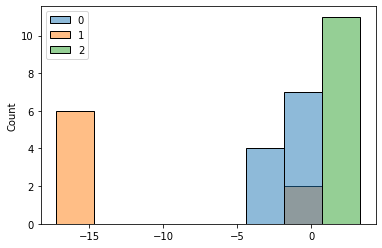

In [6]:
sns.histplot(fig1_wavelets.apply(lambda x: np.log10(x)))

In [7]:
(fig1_wavelets > 0).sum()

0    11
1     8
2    11
dtype: int64

In [8]:
fig1_wavelets = fig1_wavelets.rename(columns={0:'Trait 1', 1:'Trait 2', 2:'Trait 3'})

In [9]:
def fig1_layout(node, tip_data, wavelet_data, trait):
    '''
    Layout function for tree generated by collapse_to_phylum
    '''
    # print(node.name)
    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    internal_ns['vt_line_width'] = 1
    internal_ns['hz_line_width'] = 1
    
    if node.is_leaf():
        cm = matplotlib.colormaps['gnuplot']
        if tip_data.loc[node.name, trait] != 0:
            c = to_hex(cm(tip_data.loc[node.name, trait]))
        else:
            c = '#808080'
        R1 = RectFace(width=4, height=4, fgcolor=c, bgcolor=c)
        faces.add_face_to_node(R1, node, 0, position='aligned')
    else:
        ''
        t1 = TextFace(node.name)
        faces.add_face_to_node(t1, node, 0)
        # if np.abs(wavelet_data.loc[node.name, trait]) > 1e-15:
        #     internal_ns['size'] = 10
        

    node.img_style = internal_ns

def fig1_ts(**args):
    ts = TreeStyle()
    ts.layout_fn = lambda n: fig1_layout(n, **args)
    # ts.mode = 'c'
    ts.draw_guiding_lines = True
    ts.show_leaf_name = True
    return ts
    

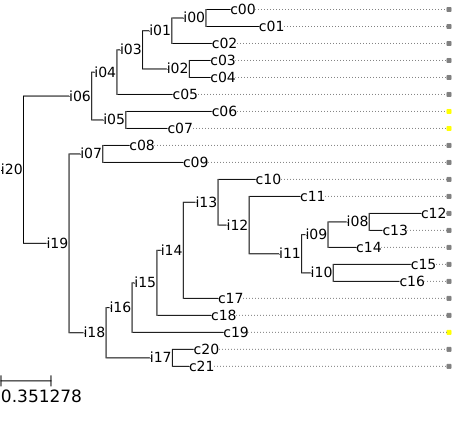

In [10]:
# fig1_tree.render('%%inline', tree_style=fig1_ts(tip_data=fig1_data, wavelet_data=fig1_wavelets, trait='Trait 2'), w=500, h=500)
fig1_tree.render('%%inline', tree_style=fig1_ts(tip_data=fig1_data, wavelet_data=fig1_wavelets, trait='Trait 2')) #, w=500, h=500)

In [38]:
rendered = fig1_tree.render('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_tree.png', tree_style=fig1_ts(tip_data=fig1_data, wavelet_data=fig1_wavelets, trait='Trait 2'), dpi=400) #  w=500, h=500)

In [11]:
nodes = [n.name for n in fig1_tree.traverse(strategy='postorder') if not n.is_leaf()]
node_postorders = dict((n, i) for n, i in zip(nodes, np.linspace(0, 1, len(nodes))))

leaves = [l.name for l in fig1_tree.traverse(strategy='postorder') if l.is_leaf()]
leaf_postorders = dict((l, i) for l, i in zip(leaves, np.linspace(0, 1, len(leaves))))

In [12]:
def fig1_post_layout(node, n_po, l_po, color=True):
    '''
    Layout function for tree generated by collapse_to_phylum
    '''
    # print(node.name)
    internal_ns = NodeStyle()
    internal_ns['size'] = 0
    # internal_ns['vt_line_width'] = 1
    # internal_ns['hz_line_width'] = 1
    
    cm = matplotlib.colormaps['gnuplot']
    
    if node.is_leaf():
        
        c = to_hex(cm(l_po[node.name]))
        if color:
            R1 = RectFace(width=4, height=4, fgcolor=c, bgcolor=c)
            faces.add_face_to_node(R1, node, 0, position='aligned')
        
    else:
        if color:
            internal_ns['vt_line_color'] = to_hex(cm(n_po[node.name]))
            internal_ns['hz_line_color'] = to_hex(cm(n_po[node.name]))
        
    node.img_style = internal_ns

def fig1_post_ts(**args):
    ts = TreeStyle()
    ts.layout_fn = lambda n: fig1_post_layout(n, **args)
    # ts.mode = 'c'
    ts.draw_guiding_lines = True
    ts.show_leaf_name = False
    ts.branch_vertical_margin = 5
    ts.show_scale = False
    # ts.scale = 500
    return ts

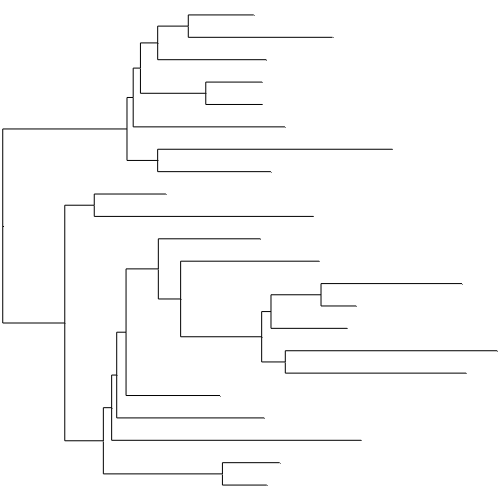

In [13]:
fig1_tree.render('%%inline', tree_style=fig1_post_ts(n_po=node_postorders, l_po=leaf_postorders, color=False), h=500, w=500)

In [14]:
rendered = fig1_tree.render('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_tree_nolabel.png', 
                 tree_style=fig1_post_ts(n_po=node_postorders, l_po=leaf_postorders, color=False), 
                 h=500, w=500)

In [15]:
rendered = fig1_tree.render('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_tree_nolabel_colored.png', 
                 tree_style=fig1_post_ts(n_po=node_postorders, l_po=leaf_postorders, color=True), 
                 h=500, w=500)

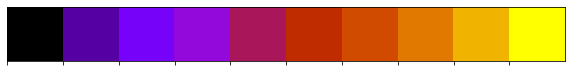

In [16]:
_cmap = cm.gnuplot
sns.palplot([_cmap(i) for i in np.linspace(0,1,10)])

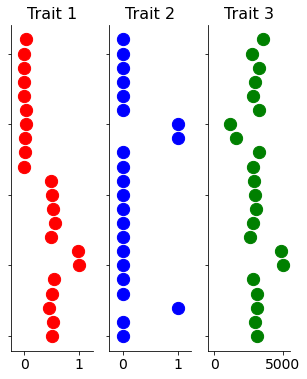

In [17]:
fig = plt.figure(figsize=(5,6))
for color, (i, col) in zip(['r', 'b', 'g'], enumerate(fig1_data.columns)):
    ax = fig.add_subplot(1,3,i+1)
    plt.scatter(y=range(len(fig1_data)), x=fig1_data.iloc[::-1][col], s=150, color=color)
    sns.despine()
    ax.set_title(col, fontsize=16)
    plt.tick_params(labelleft=False, labelsize=14)
    
    if i ==2:
        ax.set_xlim(-500, 5500)
    else:
        ax.set_xlim(-0.25, 1.25)
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_traits.png', bbox_inches='tight', dpi=400)

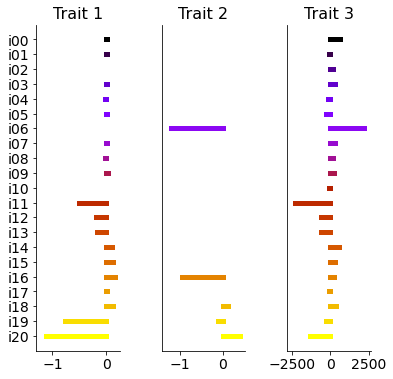

In [18]:
cm = matplotlib.colormaps['gnuplot']

fig = plt.figure(figsize=(6,6))
for i, col in enumerate(fig1_wavelets):
    ax = fig.add_subplot(1,3,i+1)
    for yval, (index, item) in enumerate(fig1_wavelets.iloc[::-1][col].items()):
        plt.plot((0, item), (yval,) * 2, color=cm(node_postorders[index]), linewidth=5)
    sns.despine()
    ax.set_title(col, fontsize=16)
    plt.tick_params(left=False, labelleft=False, labelsize=14)
    xlims = ax.get_xlim()
    ax.set_xlim(xlims[0]*1.1, xlims[1]*1.1)
    if i == 0:
        ax.set_yticks(range(len(fig1_wavelets.iloc[::-1].index)))
        ax.set_yticklabels(fig1_wavelets.iloc[::-1].index)
        plt.tick_params(left=True, labelleft=True, labelsize=14)
    # if i ==2:
    #     ax.set_xlim(-500, 5500)
    # else:
    #     ax.set_xlim(-0.25, 1.25)
    
fig.subplots_adjust(wspace=0.5)
plt.savefig('/data/mhoffert/fiererlab/periodic_phyla/figures/group_meeting_figures/fig1_wavelets.png', bbox_inches='tight', dpi=400)

In [19]:
from sklearn.manifold import TSNE

In [20]:
from scipy.optimize import linear_sum_assignment

In [21]:
def gridify(points, grid_size):
    # Generate random points in x,y space
    np.random.seed(143)  # for reproducibility

    locations = np.array(list(itertools.product(range(grid_size), range(grid_size))))

    # Define the distance function (squared Euclidean distance)
    distance = lambda point, location: np.sum((point - location) ** 2)

    # Initialize the cost matrix
    cost_matrix = np.zeros((len(points), grid_size**2))

    # Populate the cost matrix with distances
    for i, point in enumerate(points):
        for j, location in enumerate(locations):
            cost_matrix[i, j] = distance(point, location)

    # Solve the assignment problem to minimize the total distance
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Assign points to locations based on the optimal solution
    assignments = locations[col_ind].reshape(-1, 2)
    
    return assignments

In [22]:
ilist = ['i04', 'i05', 'i07', 'c10', 'c11', 'i09', 'i10', 'c17', 'c18', 'c19', 'i17']
i_map = dict((i, [l.name for l in fig1_tree.search_nodes(name=i)[0].get_leaves()]) for i in ilist)

rev_i_map = {}
for key, item in i_map.items():
    for i in item:
        rev_i_map[i] = key

fig1_tsne_data = fig1_data.groupby(rev_i_map).mean()

In [23]:
%%time
tsne_embedding = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3, n_jobs=10).fit_transform(fig1_tsne_data.values)

CPU times: user 12min 17s, sys: 977 ms, total: 12min 18s
Wall time: 25.5 s


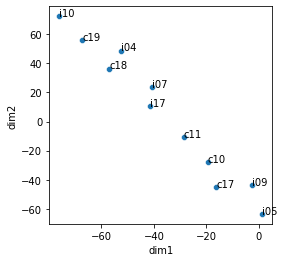

In [24]:
fig, ax = plt.subplots(figsize=(4,4))
tsne_plotdf = pd.DataFrame(tsne_embedding, columns=['dim1', 'dim2'], index=fig1_tsne_data.index)
sns.scatterplot(data=tsne_plotdf, x='dim1', y='dim2')
for index, row in tsne_plotdf.iterrows():
    ax.annotate(text=index, xy=(row['dim1'], row['dim2']))

In [25]:
grid_size = 4
tsne_grid = gridify(tsne_plotdf.values, 4)

In [26]:
tsne_grid_df = pd.DataFrame(tsne_grid, index=tsne_plotdf.index, columns=['dim1', 'dim2'])

In [27]:
grid_spots = np.array(list(itertools.product(np.linspace(tsne_plotdf['dim1'].min(),
                             tsne_plotdf['dim1'].max(),
                             grid_size),
                  np.linspace(tsne_plotdf['dim2'].min(),
                             tsne_plotdf['dim2'].max(),
                             grid_size)))).reshape(grid_size, grid_size, 2)

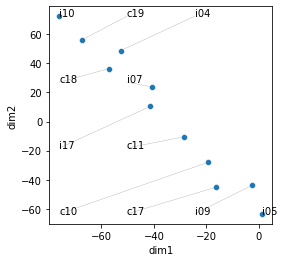

In [28]:
# plot to visualizing snapping
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=tsne_plotdf, x='dim1', y='dim2')
for index, row in tsne_grid_df.iterrows():
    grid_x, grid_y = grid_spots[tsne_grid_df.loc[index, 'dim1']][tsne_grid_df.loc[index, 'dim2']]
    plt.plot((grid_x, tsne_plotdf.loc[index, 'dim1']),
             (grid_y, tsne_plotdf.loc[index, 'dim2']), color='gray', linewidth=0.25, zorder=0)
    ax.annotate(index, (grid_x, grid_y))
# assignments